<h1><center>TP1 - Régression Linéaire</center></h1>
<hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sns.set_theme()

# Mode inline (graphiques simples)
#%matplotlib inline
#plt.rcParams["figure.figsize"] = (16,9)

# Mode notebook (graphiques interactifs)
%matplotlib notebook
plt.rcParams["figure.figsize"] = (8, 6)

Le script ci-dessous évite le scroll sur les graphiques

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Question 1

Importation de la base de données `"invest.txt"` et affichage des 5 premières observations.

In [3]:
df = pd.read_csv('invest.txt', delimiter=" ")

In [4]:
df.head()

,year,gnp,invest,cpi,interest
0,1968,873.4,133.3,82.54,5.16
1,1969,944.0,149.3,86.79,5.87
2,1970,992.7,144.2,91.45,5.95
3,1971,1077.6,166.4,96.01,4.88
4,1972,1185.9,195.0,100.00,4.50


## Question 2

On visualise ci-dessous la variable à expliquer `Investment` en fonction de la variable explicative `GNP`, les deux en échelle logarithmique.

In [5]:
# Création des variables en log
df['gnp_log'] = np.log(df.gnp)
df['invest_log'] = np.log(df.invest)

<IPython.core.display.Javascript object>


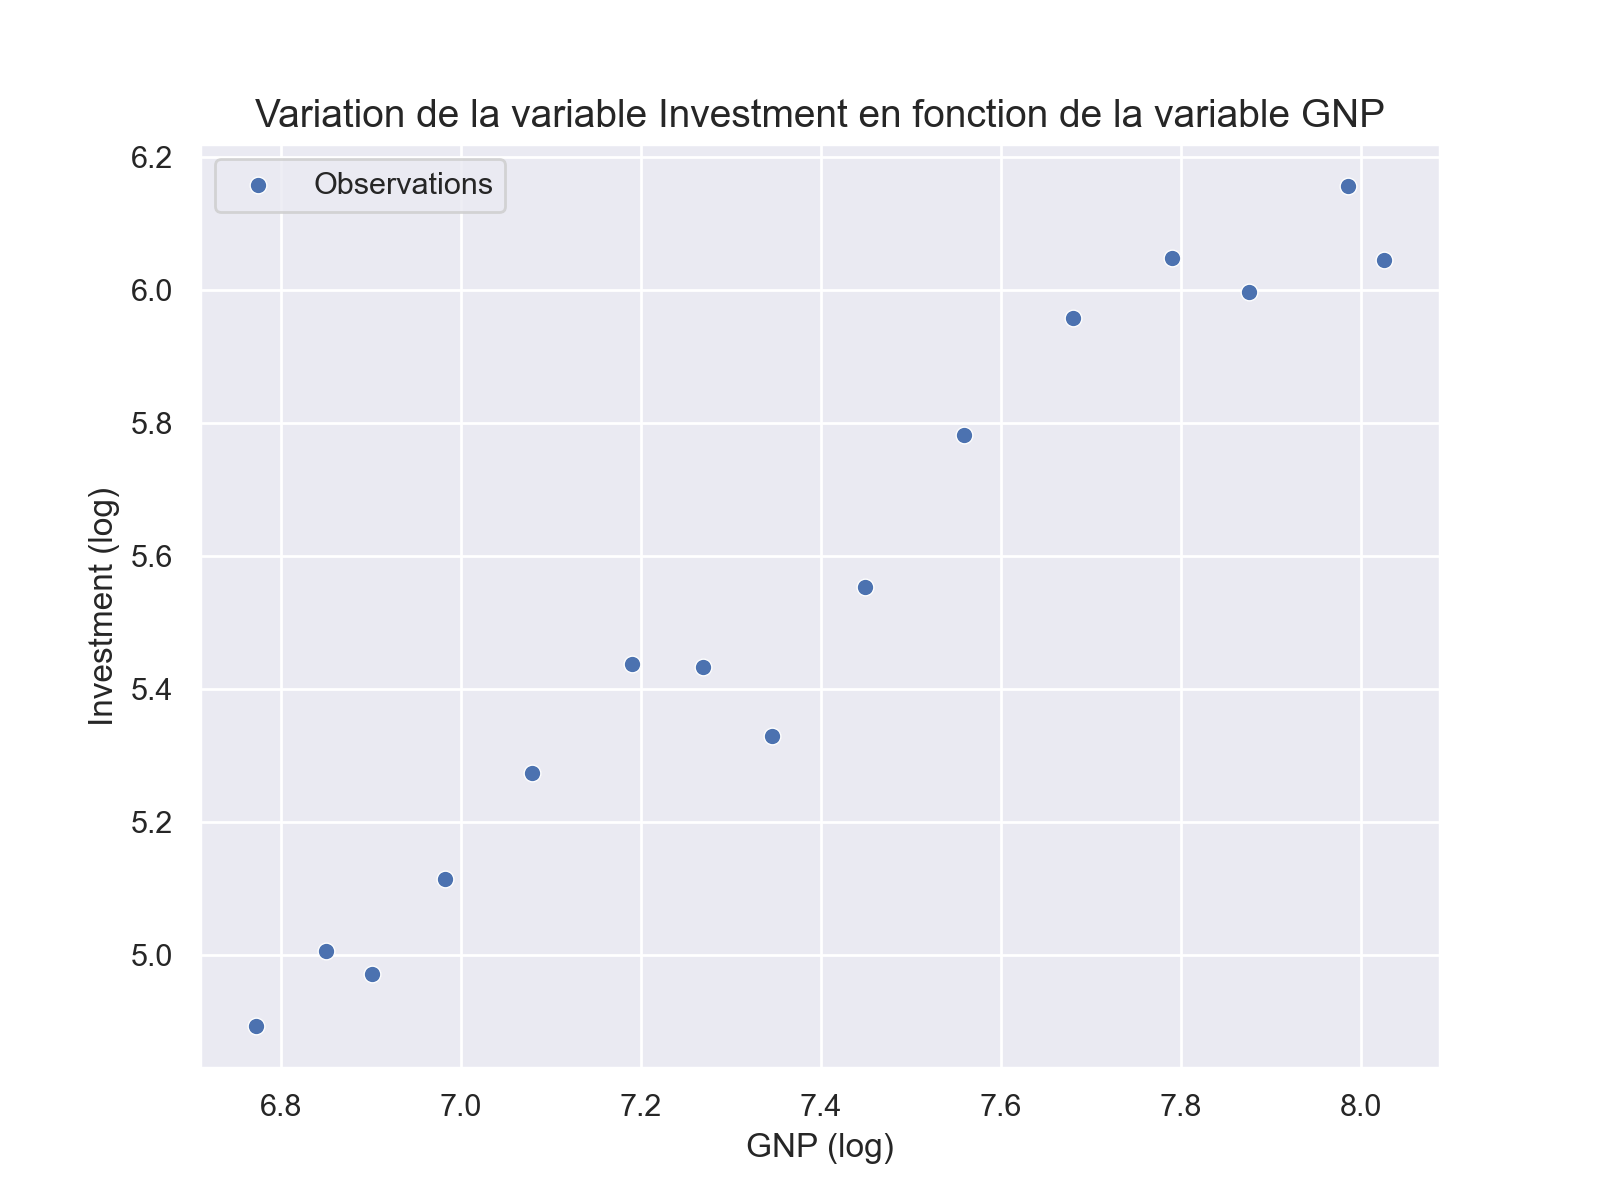

In [6]:
# Affichage du résultat
figure = plt.figure()
ax = sns.scatterplot(x="gnp_log", y="invest_log", data=df, label="Observations")
ax.set_title("Variation de la variable Investment en fonction de la variable GNP", size=14)
ax.set_xlabel('GNP (log)')
ax.set_ylabel('Investment (log)')
ax.legend();

## Question 3

Précisons avant toute chose que nous nous plaçons sous l'hypothèse d'un modèle de bruit gaussien, à savoir :
$$
Y_i = \beta_0 + \beta_1 * x_i + \epsilon_i \text{  , où  } \epsilon_i \sim \mathcal{N}(0, 1)
$$


Nous calculons l'intercept et la pente de la régression avec les formules suivantes (estimation des moindres carrés) :

$$
\hat{\beta}_0 = \bar{Y}^n - \hat{\beta}_1 \bar{x}^n \text{ et }\
\hat{\beta}_1 = \frac{\sum_{i=0}^n (x_i - \bar{x}^n)(Y_i - \bar{Y}^n)} {\sum_{i=0}^n (x_i - \bar{x}^n)^2}
$$

où $\bar{x}^n$ et $\bar{Y}^n$ sont les moyennes empiriques des suites $(x_i)_i$ et $(Y_i)_i$, avec $x_i$ non constants.

Pour ce qui est des écarts-types des paramètres de régression, nous utiliserons les formules suivantes qui décrivent l'estimation des variances (cf. poly) :

$$
\mathbb{V}\left[\hat{\beta}_{0}\right]=\hat{\sigma}^{2}\left(\frac{1}{n}+\frac{\bar{x}^{n 2}}{\sum_{i=1}^{n}\left(x_{i}-\bar{x}^{n}\right)^{2}}\right) \quad \text { et } \quad \mathbb{V}\left[\hat{\beta}_{1}\right]=\frac{\hat{\sigma}^{2}}{\sum_{i=1}^{n}\left(x_{i}-\bar{x}^{n}\right)^{2}}
$$

où $\hat{\sigma}^{2}$ est l'estimateur (sans biais) du niveau de bruit : $\hat{\sigma}^{2}=\frac{1}{n-2} \sum_{i=1}^{n}\left(Y_{i}-\left(\hat{\beta}_{0}+\hat{\beta}_{1} x_{i}\right)\right)^{2}$

Enfin, le coefficient de détermination est défini par la formule suivante :
$$
R^2 = 1 - \frac{\sum_{i=0}^n (y_i - \hat{y}_i)^2} {\sum_{i=0}^n (y_i - \bar{y}^n)^2}
$$

In [7]:
# Introduction des variables explicatives et à expliquer
x = df.gnp_log.to_numpy()
y = df.invest_log.to_numpy()    
n = x.shape[0]

# Calcul des moyennes
x_mean = x.mean()
y_mean = y.mean()

# Calcul de l'intercept et de la pente 
beta1 = np.dot(x - x_mean, y - y_mean) / np.linalg.norm(x - x_mean) ** 2
beta0 = y_mean - beta1 * x_mean

# Calcul des valeurs estimées yi et de l'estimation du niveau de bruit
y_hat = beta1 * x + beta0
noise_hat = np.linalg.norm(y - y_hat) ** 2 / (n - 2)

# Calcul des écarts types des paramètres de regression
beta0_std = noise_hat * (1 / n + x_mean ** 2 / np.linalg.norm(x - x_mean) ** 2)
beta0_std = np.sqrt(beta0_std)
beta1_std = noise_hat / np.linalg.norm(x - x_mean) ** 2
beta1_std = np.sqrt(beta1_std)

# Calcul du coefficient de détermination
R2 = 1 - np.linalg.norm(y_hat - y) ** 2 / np.linalg.norm(y - y_mean) ** 2

print(f"L'intercept de la régression est : \t{beta0:.3f}")
print(f"La pente de la régression est : \t{beta1:.3f}")
print(f"L'écart-type pour l'intercept est : \t{beta0_std:.3f}")
print(f"L'écart-type pour la pente est : \t{beta1_std:.3f}")
print(f"Le coefficient de détermination est : \t{R2:.3f}")

L'intercept de la régression est : 	-1.964
La pente de la régression est : 	1.015
L'écart-type pour l'intercept est : 	0.410
L'écart-type pour la pente est : 	0.055
Le coefficient de détermination est : 	0.963


**On notera que le coefficient de détermination est proche de 1, ce qui tend à montrer que les points observés sont rassemblés autour de la droite de régression (un coefficient de 0 montrerait que le nuage de point est dispersé autour de cette droite) : l'estimation est donc plutôt bonne au regard de ce score.**

## Question 4

Une pente estimée est statistiquement significative si elle permet d'apporter une information sur la relation entre les variables `GNP` et `Investment`, i.e. elle est statistiquement non nulle.
Aussi, faisons l'hypothèse de test suivante sur l'estimation de la pente :

$$
\mathcal{H}_0 : \beta_1 = 0
$$

Montrons alors que cette hypothèse peut être rejetée avec un niveau élevé.

Comme nous sommes dans le cas d'un bruit gaussien, nous avons les résultats suivants (cf. cours) :

$$
\frac{\sqrt{n} (\hat{\beta}_i - \beta_i)}{\sqrt{\sigma^2 (G^{-1})_{ii}}} \sim \mathcal{N}(0, 1) ~
\text{  et  } ~ (n-p-1)(\hat{\sigma}^2 / \sigma^2) \sim \chi^2_{n-p-1}(0, 1)
$$

et ainsi par définition :

$$
\sqrt{\frac{n}{(G^{-1})_{ii} \hat{\sigma}^2}} (\hat{\beta}_i - \beta_i) \sim \mathcal{T}_{n-p-1}(0, 1)
$$

où $G$ est la matrice de Gram, p le rang de la matrice des valeurs explicatives (Z dans le cours) et 
$\mathcal{T}_{n-p-1}$ la loi de Student à (n-p-1) degrés de liberté.

Dans notre cas, $p = 1$ (car $x_i$ non constants), $\beta_1 = 0$ et $(G^{-1})_{ii} = \frac{n}{\sum_{i=1}^{n}\left(x_{i}-\bar{x}^{n}\right)^{2}}$, donc la statistique de test $\hat{T} = \hat{\beta}_1 / \sqrt{\mathbb{V}\left[\hat{\beta}_{1}\right]}$ suit une loi de Student à (n-2) degrés de liberté.

In [8]:
# Calcul de la statistique de test au regard des observations
stat_val = beta1 / beta1_std

print(f"La valeur observée tn de la statistique de test pour la pente est : {stat_val:.3f}")

La valeur observée tn de la statistique de test pour la pente est : 18.332


De façon schématique, la p-valeur est la probabilité que la statistique $\hat{T}$ dépasse la valeur observée $t_n$. Dans le cas où la loi de la statistique est symétrique et le test est bilatère, elle se définit alors ainsi :

$$
p_{valeur} = \mathbb{P}(|\hat{T}| > t_n) = 2 ~ (1 - F_{\hat{T}}(t_n))
$$

où $F_{\hat{T}}$ est la fonction de répartition (cumulative distribution function) de la statistique de test (qui suit la loi de Student).

In [9]:
p_value = 2 * (1 - t.cdf(stat_val, n - 2))

print(f"La valeur de la p-valeur pour la pente est : {p_value}")

La valeur de la p-valeur pour la pente est : 1.1363709973011282e-10


**La p-value est extrêmement faible. En conséquence, l'hypothèse $\mathcal{H}_0$ est très peu vraisemblable et la pente estimée est donc statistiquement significative.**
En effet, si on avait défini un test avec un niveau de confiance 99.9999% ($\alpha = 10^{-6}$), alors la valeur de la statistique de test est clairement dans la zone de rejet (car la p-valeur associée est inférieur à $10^{-6}$) et notre hypothèse de départ est rejetée.

## Question 5

Pour les prédictions, on veillera à repasser la valeur calculée avec la régression en échelle linéaire :

In [10]:
GNP_ref = 1000

In [11]:
prediction = (beta0 + np.log(GNP_ref) * beta1)

print(f"Pour GNP={GNP_ref}, l'investissement prédit par le modèle est de : {np.exp(prediction):.3f} \
(en valeur log : {prediction:.3f}).")

Pour GNP=1000, l'investissement prédit par le modèle est de : 155.979 (en valeur log : 5.050).


On peut montrer que :

$$
\frac{\sqrt{n} (\hat{Y}_i - Y_i^*)}{\sqrt{\sigma^2 z_i^T(G^{-1})z_i}} \sim \mathcal{N}(0, 1) \quad \text{où}
\quad Y_i^* = \beta_0 + \beta_1 x_i ~ \quad \text{et} \quad ~ z_i = (1, x_i)^T
$$

et donc,

$$
\sqrt{\frac{n}{\hat{\sigma}^2 z_i^T(G^{-1})z_i}} (\hat{Y}_i - Y_i^*) \sim \mathcal{T}_{n-p-1}(0, 1)
$$

Dans notre cas, cette formule s'explicite ainsi :

$$
\frac{\left(\hat{\beta}_{0}+\hat{\beta}_{1} x_i\right)-\left(\beta_{0}+\beta_{1} x_i\right)}{\hat{\sigma} \sqrt{\frac{1}{n}+\frac{\left(x_i-\bar{x}^{n}\right)^{2}}{\sum_{k=1}^{n}\left(x_{k}-\bar{x}^{n}\right)^{2}}}} \sim \mathcal{T}_{n-2}(0, 1)
$$

Et donc l'intervalle $CI(z)$ de confiance au niveau 90% ($\alpha = 0.1$) pour la valeur prédite $Y_i^*$ est défini ainsi :

$$
\left[\hat{Y}_i - t_{1 - \alpha / 2}\hat{\sigma}\sqrt{\frac{1}{n}+\frac{\left(x_i-\bar{x}^{n}\right)^{2}}{\sum_{k=1}^{n}\left(x_{k}-\bar{x}^{n}\right)^{2}}} \quad ; \quad
\hat{Y}_i + t_{1 - \alpha / 2}\hat{\sigma}\sqrt{\frac{1}{n}+\frac{\left(x_i-\bar{x}^{n}\right)^{2}}{\sum_{k=1}^{n}\left(x_{k}-\bar{x}^{n}\right)^{2}}} \right]
$$

où $t_{1 - \alpha / 2}$ est le quantile d'ordre $1 - \alpha / 2$ de la loi $\mathcal{T}_{n-2}(0, 1)$.

De même, on montre que :

$$
\frac{\sqrt{n} (\hat{Y}_i - Y_i)}{\sqrt{\sigma^2 (1 + z_i^T(G^{-1})z_i)}} \sim \mathcal{N}(0, 1)
\quad \text{où} \quad Y_i = \beta_0 + \beta_1 x_i + \epsilon_i
$$

(en raison du terme supplémentaire $\epsilon_i$ au niveau du numérateur) et :

$$
\sqrt{\frac{n}{\hat{\sigma}^2 (1 + z_i^T(G^{-1})z_i)}} (\hat{Y}_i - Y_i) \sim \mathcal{T}_{n-p-1}(0, 1)
$$

ce qui s'explicite dans notre cas par la formule :

$$
\frac{\left(\hat{\beta}_{0}+\hat{\beta}_{1} x_i\right)- Y_i }{\hat{\sigma} \sqrt{1 + \frac{1}{n}+\frac{\left(x_i-\bar{x}^{n}\right)^{2}}{\sum_{k=1}^{n}\left(x_{k}-\bar{x}^{n}\right)^{2}}}} \sim \mathcal{T}_{n-2}(0, 1)
$$

Finalement, l'intervalle $PI(z)$ de confiance au niveau 90% ($\alpha = 0.1$) pour la valeur à expliquer `Investment` $Y_i$ est défini ainsi :

$$
\left[\hat{Y}_i - t_{1 - \alpha / 2}\hat{\sigma}\sqrt{1 + \frac{1}{n}+\frac{\left(x_i-\bar{x}^{n}\right)^{2}}{\sum_{k=1}^{n}\left(x_{k}-\bar{x}^{n}\right)^{2}}} \quad ; \quad
\hat{Y}_i + t_{1 - \alpha / 2}\hat{\sigma}\sqrt{1 + \frac{1}{n}+\frac{\left(x_i-\bar{x}^{n}\right)^{2}}{\sum_{k=1}^{n}\left(x_{k}-\bar{x}^{n}\right)^{2}}} \right]
$$

In [12]:
# Calcul de CI au niveau 90%
t_90 = t.ppf(1 - (0.1/ 2), n - 2)
temp = 1 / n + ((np.log(GNP_ref) - x_mean) ** 2) / (np.linalg.norm(x - x_mean) ** 2)

CI_coef = t_90 * np.sqrt(noise_hat) * np.sqrt(temp)
CI_inf = np.exp(beta0 + beta1 * np.log(GNP_ref) - CI_coef)
CI_sup = np.exp(beta0 + beta1 * np.log(GNP_ref) + CI_coef)

# Calcul de PI au niveau 90%
temp = temp + 1
PI_coef = t_90 * np.sqrt(noise_hat) * np.sqrt(temp)
PI_inf = np.exp(beta0 + beta1 * np.log(GNP_ref) - PI_coef)
PI_sup = np.exp(beta0 + beta1 * np.log(GNP_ref) + PI_coef)

print(f"Pour GNP={GNP_ref}, l'intervalle de confiance au niveau 90% pour " \
      f"la variable prédite Y* est : [{CI_inf:.3f}, {CI_sup:.3f}]")
print(f"(en valeurs log : [{np.log(CI_inf):.3f}, {np.log(CI_sup):.3f}]).\n")

print(f"Pour GNP={GNP_ref}, l'intervalle de confiance au niveau 90% pour " \
      f"la variable à expliquer Y est : [{PI_inf:.3f}, {PI_sup:.3f}]")
print(f"(en valeurs log : [{np.log(PI_inf):.3f}, {np.log(PI_sup):.3f}]).\n")

Pour GNP=1000, l'intervalle de confiance au niveau 90% pour la variable prédite Y* est : [146.676, 165.873]
(en valeurs log : [4.988, 5.111]).

Pour GNP=1000, l'intervalle de confiance au niveau 90% pour la variable à expliquer Y est : [132.002, 184.312]
(en valeurs log : [4.883, 5.217]).



**Il est normal d'avoir un intervalle de confiance plus large pour $Y$ que pour $Y^*$, en raison de la variable de bruit supplémentaire $\epsilon$ dans $Y$, qu induit naturellement une plus grande incertitude et qui mathématiquement se répercute par une unité en plus dans la racine carrée qui définit la largeur de l'intervalle.**

## Question 6

<IPython.core.display.Javascript object>


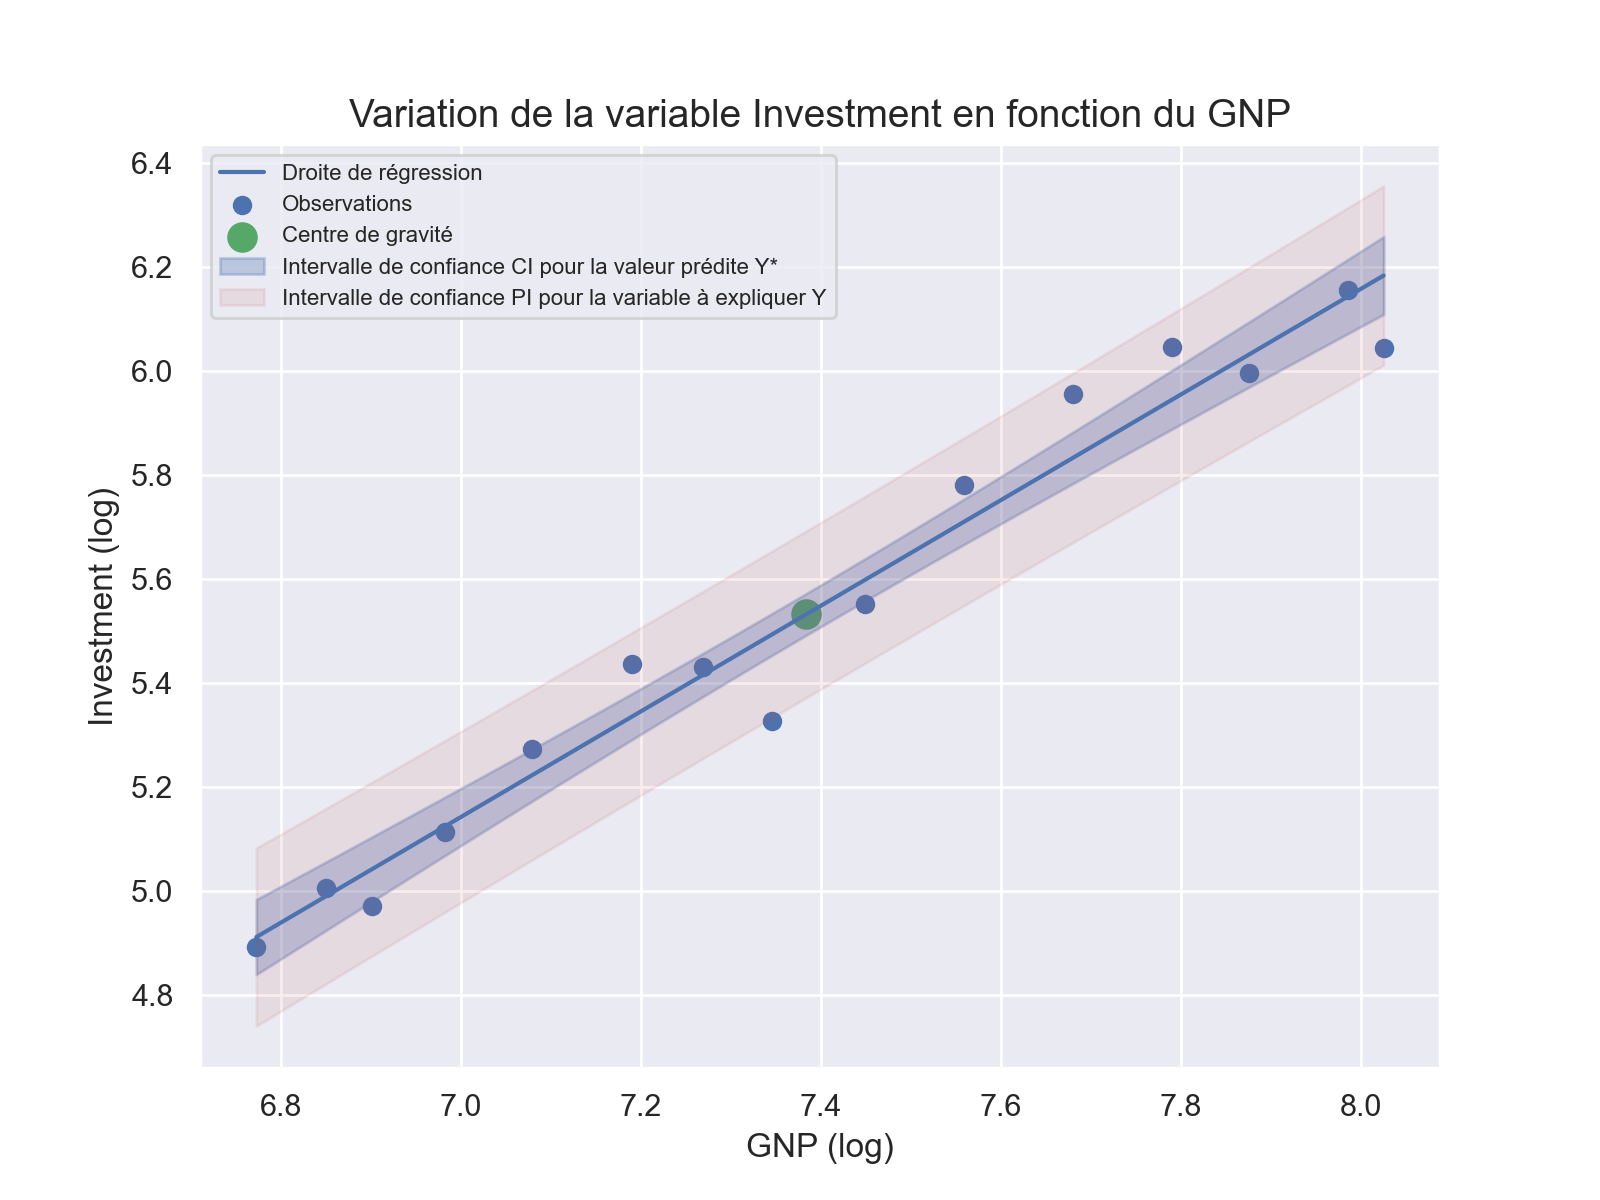

In [13]:
# Génération de l'axe des abscisses
x_min = df.gnp_log.min()
x_max = df.gnp_log.max()
x_abs = np.linspace(x_min, x_max, num=100)

# Génération de la droite de régression
y_hat = beta0 + beta1 * x_abs

# Génération des intervalles de confiance CI
temp = 1 / n + ((x_abs - x_mean) ** 2) / ((np.linalg.norm(x - x_mean) ** 2))
CI_width = t_90 * np.sqrt(noise_hat) * np.sqrt(temp)
CI_inf = y_hat - CI_width
CI_sup = y_hat + CI_width

# Génération des intervalles de confiance PI
temp = temp + 1
PI_width = t_90 * np.sqrt(noise_hat) * np.sqrt(temp)
PI_inf = y_hat - PI_width
PI_sup = y_hat + PI_width

# Affichage des courbes
fig, ax = plt.subplots()

ax.plot(x_abs, y_hat, label="Droite de régression")
ax.scatter(x, y, label="Observations")
ax.scatter(x_mean, beta0 + beta1 * x_mean, label="Centre de gravité",
           color='g', s=100)
ax.fill_between(x_abs, CI_inf, CI_sup, color='b', alpha=.3,
                label='Intervalle de confiance CI pour la valeur prédite Y*')
ax.fill_between(x_abs, PI_inf, PI_sup, color='r', alpha=.1,
                label='Intervalle de confiance PI pour la variable à expliquer Y')

ax.set_xlabel('GNP (log)')
ax.set_ylabel('Investment (log)')
ax.set_title('Variation de la variable Investment en fonction du GNP', size=14)
ax.legend(loc="upper left", fontsize=8);

Les zones de confiance CI et PI décrivent une forme de type hyperbolique (en "diabolo"), centrées sur le point de gravité de l'échantillon ($\bar{x}^{n}$, $\bar{y}^{n}$).
En effet, on peut montrer, à travers les variables centrées et réduites, que la pente passe par le centre de gravité et que la pente se 'construit' par l'influence des points environnants, cette influence étant d'autant plus importante que le point est éloigné du centre de gravité. On explique ainsi que l'intervalle de confiance est plus réduit au niveau du centre de gravité qu'aux "extrémités" de la droite.

## Question 7

In [14]:
# Initialisation et fit de l'estimateur
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y.reshape(-1, 1));

In [15]:
# Affichage des principales valeurs
beta0_lr = lr.intercept_[0]
beta1_lr = lr.coef_[0, 0]

print(f"L'intercept de la régression est : {beta0_lr:.3f}")
print(f"La pente de la régression est : {beta1_lr:.3f}")

y_hat_lr = beta0_lr + beta1_lr * x

print(f"Le coefficient de détermination est : {r2_score(y, y_hat_lr):.3f}")

y_hat_ref = lr.predict(np.log(GNP_ref).reshape(-1, 1))
y_hat_ref = np.exp(y_hat_ref[0][0]) 

print(f"Pour GNP={GNP_ref}, l'investissement prédit par le modèle est de : {y_hat_ref:.3f}")

L'intercept de la régression est : -1.964
La pente de la régression est : 1.015
Le coefficient de détermination est : 0.963
Pour GNP=1000, l'investissement prédit par le modèle est de : 155.979


**Nous retrouvons les valeurs des questions 4 et 9.**

## Question 8

<IPython.core.display.Javascript object>


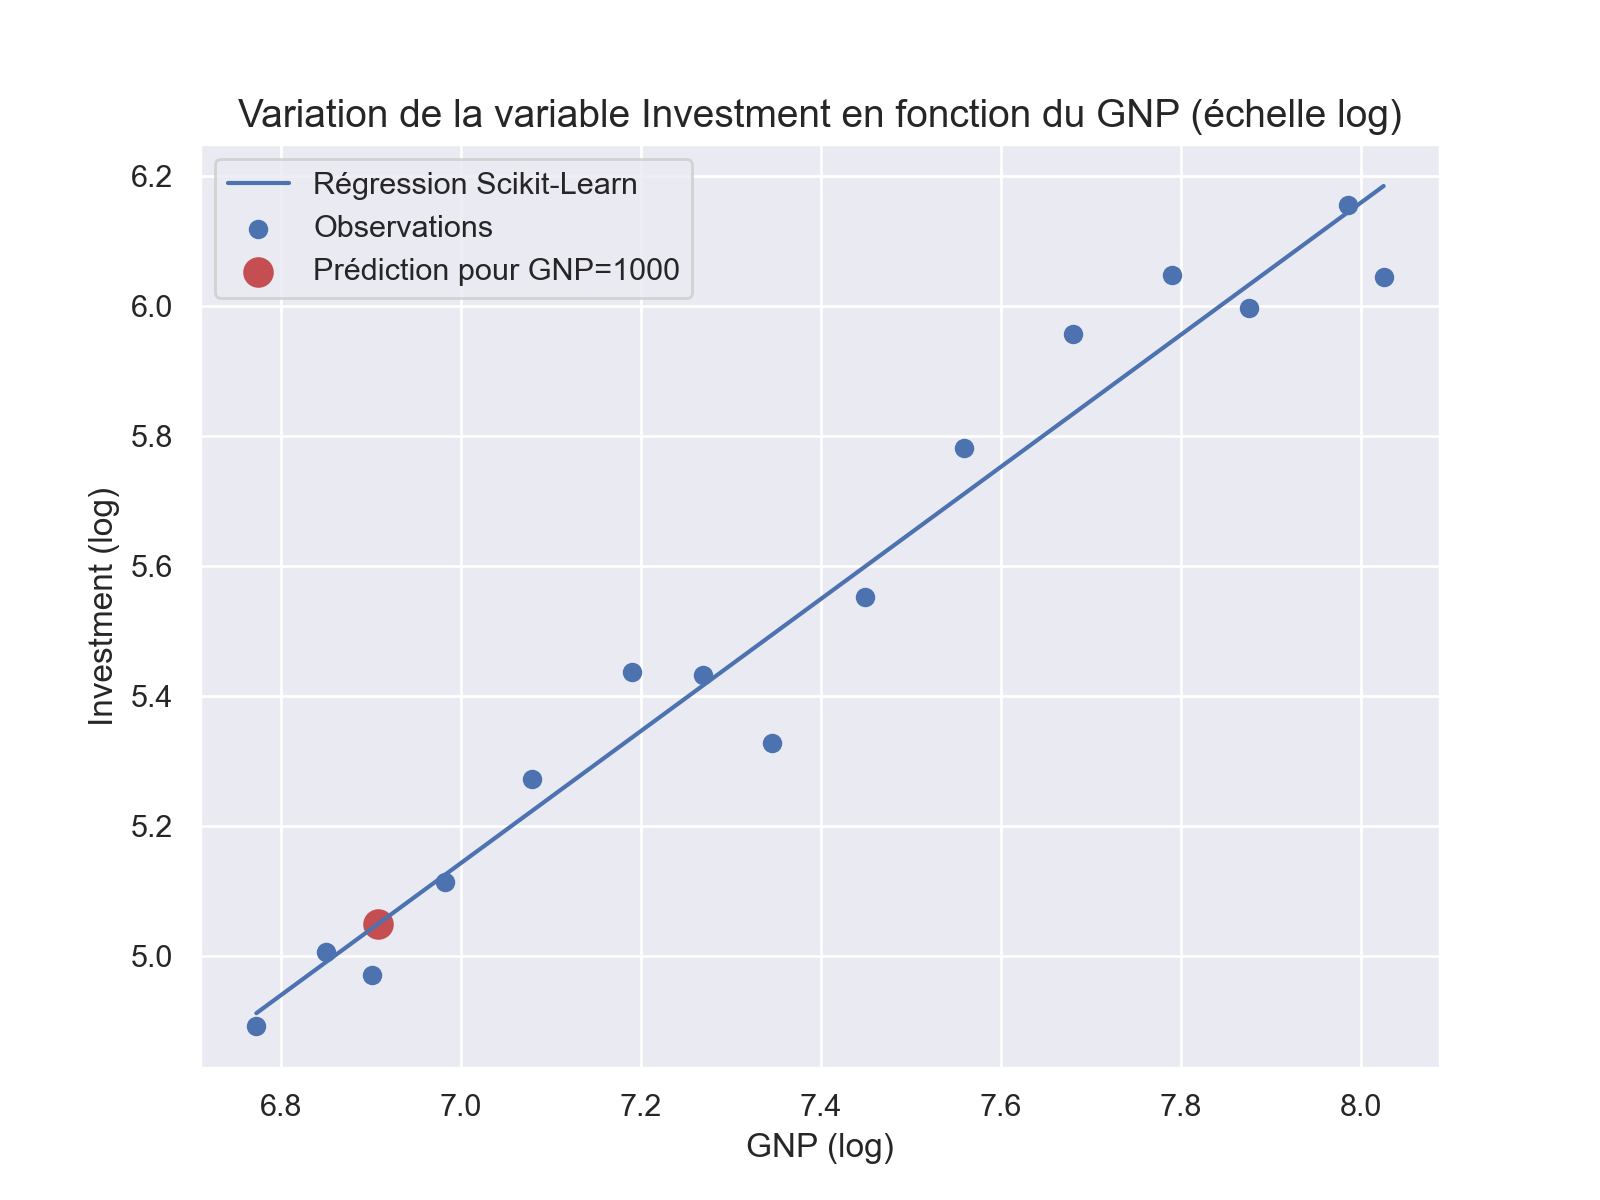

In [16]:
# Génération de l'axe des abscisses
x_min = df.gnp_log.min()
x_max = df.gnp_log.max()
x_abs = np.linspace(x_min, x_max, num=100)

# Génération de la droite de régression avec le modèle de Scikit Learn
y_hat = beta0_lr + beta1_lr * x_abs

# Affichage des graphiques
fig, ax = plt.subplots()
ax.plot(x_abs, y_hat, label="Régression Scikit-Learn")
ax.scatter(x, y, label="Observations")
ax.scatter([np.log(GNP_ref)], [np.log(y_hat_ref)], color='r',
           label=f'Prédiction pour GNP={GNP_ref}', s=100)
ax.set_xlabel('GNP (log)')
ax.set_ylabel('Investment (log)')
ax.set_title('Variation de la variable Investment en fonction du GNP (échelle log)', size=14)
ax.legend();

## Question 9

On introduit la variable explicative `interest`.
On calcule la matrice de Gram $G$ qui a la forme suivante :

$$
G = \frac{Z^T Z}{n} \quad \text{où} ~ Z \in \mathbb{R}^{n \times p+1} ~ \text{est la matrice avec les variables explicatives et n est le nombre d'observations.}
$$

**Pour savoir si la matrice est de rang plein, il suffit de calculer son déterminant (si le déterminant est non nul, alors la matrice n'a aucune valeur propre nulle et est donc de rang plein).**

In [17]:
# Calcul de la matrice de Gram
z = np.array([np.ones(n), df.gnp_log.to_numpy(), df.interest.to_numpy()]).transpose()
gram = np.dot(z.transpose(), z)

print(f"La matrice de Gram nopn standardisée est :\n{gram}\n")
print(f"Le déterminant de la matrice de Gram non standardisée est {np.linalg.det(gram):.3f}.")
print(f"Le déterminant est non nulle donc la matrice est de rang plein (rang(G)=3).")

La matrice de Gram nopn standardisée est :
[[ 15.         110.75282116 111.79      ]
 [110.75282116 820.24847688 839.18854302]
 [111.79       839.18854302 943.8557    ]]

Le déterminant de la matrice de Gram non standardisée est 1306.218.
Le déterminant est non nulle donc la matrice est de rang plein (rang(G)=3).


## Question 10

Pour estimer le vecteur des coefficients de regression $\hat{\beta}$, on utilise la formule ci-dessous, dérivée des équations normales (car $G = (Z^T Z)/n$ est de rang plein et donc inversible) :
$$
\hat{\beta} = (Z^T Z)^{-1} Z^T Y
$$

In [18]:
# Calcul des coefficients de régression
gram_inverse = np.linalg.inv(gram)
hz = np.dot(gram_inverse, z.transpose())
beta = np.dot(hz, y)

print(f"La valeur de l'intercept est : {beta[0]:.4f}")
print(f"La valeur du coefficient de régression pour la variable GNP est : {beta[1]:.4f}")
print(f"La valeur du coefficient de régression pour la variable Interest est : {beta[2]:.4f}")

La valeur de l'intercept est : -2.1805
La valeur du coefficient de régression pour la variable GNP est : 1.0512
La valeur du coefficient de régression pour la variable Interest est : -0.0065


On rappelle l'estimation de la variance pour $\hat{\beta}_i$ (généralisation des formules introduites à la question 3) :
$$
\mathbb{V}(\hat{\beta}_i) = \hat{\sigma}^2 (Z^T Z)^{-1}_{ii} = \frac {\hat{\sigma}^2}{n} (G)^{-1}_{ii}
$$
où $\hat{\sigma}^2 = \frac{1}{n-3} \|Y - \hat{Y}\|^2$, dans le cas d'une matrice de Gram de rang 3.

In [19]:
# Calcul de l'estimateur du niveau de bruit
y_hat3 = np.dot(z, beta)
noise_hat3 = (1 / (n - 3)) * (np.linalg.norm(y - y_hat3) ** 2)

# Calcul des écarts-types estimés des coefficients beta
cov_beta = noise_hat3 * gram_inverse
std_beta = np.array([np.sqrt(cov_beta[i, i]) for i in range(3)])

print(f"La valeur estimée de la variance pour l'intercept est : {std_beta[0]:.4f}")
print(f"La valeur pour la variance du coefficient de régression lié à GNP est : {std_beta[1]:.4f}")
print(f"La valeur pour la variance du coefficient de régression lié à Interest est : {std_beta[2]:.4f}")

La valeur estimée de la variance pour l'intercept est : 0.6624
La valeur pour la variance du coefficient de régression lié à GNP est : 0.1021
La valeur pour la variance du coefficient de régression lié à Interest est : 0.0153


In [20]:
# Calcul du coefficient de détermination
coef_deter = 1 - (np.linalg.norm(y - y_hat3) / np.linalg.norm(y - y_mean)) ** 2

print(f"Le coefficient de détermination est de : {coef_deter:.3f}")

Le coefficient de détermination est de : 0.963


Pour l'évaluation de la statistique de test et de la p-valeur, on reprend les formule de la question 4 :

$$
\sqrt{\frac{n}{(G^{-1})_{ii} \hat{\sigma}^2}} (\hat{\beta}_i - \beta_i) \sim \mathcal{T}_{n-p-1}(0, 1)
$$

et

$$
p_{valeur} = \mathbb{P}(|\hat{T}| > t_n) = 2 ~ (1 - F_{\hat{T}}(t_n))
$$

où $F_{\hat{T}}$ est la fonction de répartition (cumulative distribution function) de la statistique de test (qui suit la loi de Student).

Pour le test de significativité, on part de l'hypothèse suivante pour tout $\beta_i$ :

$$
\mathcal{H}_0 : \beta_i = 0
$$

In [21]:
# Calcul de la statistique de test qui suit la loi de Student
stat_beta = beta / std_beta

print(f"La statistique de test pour l'intercept est : {stat_beta[0]:.4f}")
print(f"La statistique de test pour le coefficient de régression lié à GNP est : {stat_beta[1]:.4f}")
print(f"La statistique de test pour le coefficient de régression lié à Interest est : {stat_beta[2]:.4f}")

La statistique de test pour l'intercept est : -3.2918
La statistique de test pour le coefficient de régression lié à GNP est : 10.3001
La statistique de test pour le coefficient de régression lié à Interest est : -0.4255


In [22]:
# Calcul des p-valeurs associées
pvaleur_beta = 2 * (1 - t.cdf(np.abs(stat_beta), df=n-3))

print(f"La p-valeur pour l'intercept est : {pvaleur_beta[0]}")
print(f"La p-valeur pour le coefficient de régression lié à GNP est : {pvaleur_beta[1]}")
print(f"La p-valeur pour le coefficient de régression lié à Interest est : {pvaleur_beta[2]}")

La p-valeur pour l'intercept est : 0.006438367050893179
La p-valeur pour le coefficient de régression lié à GNP est : 2.5995168484449493e-07
La p-valeur pour le coefficient de régression lié à Interest est : 0.678007141882099


Pour un test à 95% (test de niveau de confiance $1-\alpha \geq 95\%$ où $\alpha$ est le risque de rejet à tort), la région de rejet est atteinte quand la p-valeur est inférieure à $(1-0.95)/2=0.025$. Dans ce cas, **on peut considérer que le test ne permet pas de rejeter l'hypothèse $\mathcal{H}_0$ pour le coefficient liée à la variable `Interest` et de ce fait, on ne peut considérer le coefficient comme significatif**. En revanche, pour l'intercept et le coefficient lié à la variable `GNP`, on peut estimer que leur valeur est significative.

**En revanche, si on définit un test à 99%, la région de rejet est cette fois-ci atteinte por toute p-valeur inférieure à 0.005. Et dans cette configuration, ni l'intercept, ni le coefficient lié à `Interest` ne peuvent être jugés significatifs.**

## Question 11

In [23]:
# Prédiction de Investment pour GNP=1000 et Interest=10
ref = [1, 1000, 10]
z_predict = np.array([ref[0], np.log(ref[1]), ref[2]])
y_predict = np.dot(z_predict, beta)

print(f"Pour GNP={ref[1]} et Interest={ref[2]}, \
on a une valeur estimée pour Invest de : {np.exp(y_predict):.1f} ( en valeur log : {y_predict:.2f}).")


Pour GNP=1000 et Interest=10, on a une valeur estimée pour Invest de : 150.8 ( en valeur log : 5.02).


Pour les intervalles de confiance, on reprend les formules générales présentées dans la question 5.

Ainsi, l'intervalle $CI(z)$ de confiance au niveau 99.9% ($\alpha = 0.0005$) pour la valeur prédite $Y_i^*$ est défini ainsi :

$$
\left[\hat{Y}_i - t_{1 - \alpha / 2}\hat{\sigma}{\sqrt{\frac{z_i^T(G^{-1})z_i}{n}}} \quad ; \quad
\hat{Y}_i + t_{1 - \alpha / 2}\hat{\sigma}{\sqrt{\frac{z_i^T(G^{-1})z_i}{n}}}  \right]
$$

et l'intervalle $PI(z)$ de confiance au niveau 99.9% ($\alpha = 0.0005$) pour la valeur à expliquer $Y_i$ est défini ainsi :

$$
\left[\hat{Y}_i - t_{1 - \alpha / 2}\hat{\sigma}{\sqrt{1 + \frac{z_i^T(G^{-1})z_i}{n}}} \quad ; \quad
\hat{Y}_i + t_{1 - \alpha / 2}\hat{\sigma}{\sqrt{1 + \frac{z_i^T(G^{-1})z_i}{n}}}  \right]
$$

In [24]:
# Calcul du quantile à 99,9%
t_999 = t.ppf(1 - (0.001/ 2), df=n-3)

# Calcul de l'intervalle de confiance pour Y*
temp = np.dot(z_predict, gram_inverse)
temp = np.dot(temp, z_predict.transpose())
CI_width = t_999 * np.sqrt(noise_hat3) * np.sqrt(temp)
CI_inf = y_predict - CI_width
CI_sup = y_predict + CI_width

print(f"Pour une prédiction de l'Investment à {np.exp(y_predict):.1f} (en valeur log : {y_predict:.3f}), \
l'intervalle de confiance CI à 99.9% pour\nla valeur prédite est [{np.exp(CI_inf):.3f}, {np.exp(CI_sup):.3f}] \
(en valeurs log : [{CI_inf:.3f}, {CI_sup:.3f}]).\n")

# Calcul de l'intervalle de confiance pour Y
temp = 1 + temp
PI_width = t_999 * np.sqrt(noise_hat3) * np.sqrt(temp)
PI_inf = y_predict - PI_width
PI_sup = y_predict + PI_width

print(f"Pour une prédiction de l'Investment à {np.exp(y_predict):.1f} (en valeur log : {y_predict:.3f}), \
l'intervalle de confiance PI à 99.9%\npour la valeur à expliquer est [{np.exp(PI_inf):.3f}, {np.exp(PI_sup):.3f}]\
( en valeurs log : [{PI_inf:.3f}, {PI_sup:.3f}]).")

Pour une prédiction de l'Investment à 150.8 (en valeur log : 5.016), l'intervalle de confiance CI à 99.9% pour
la valeur prédite est [103.563, 219.595] (en valeurs log : [4.640, 5.392]).

Pour une prédiction de l'Investment à 150.8 (en valeur log : 5.016), l'intervalle de confiance PI à 99.9%
pour la valeur à expliquer est [87.690, 259.346]( en valeurs log : [4.474, 5.558]).


Quand on compare avec les valeurs obtenues à la question 5 (avec seulement `GNP` comme variable explicative), on remarque les intervalles de confiance sont beaucoup plus larges. Cela est notamment dû :
- au niveau de confiance choisi qui est passé de 90% à 99,9%,
- l'intégration de la 2nde valeur explicative `Interest` qui introduit de l'incertitude supplémentaire (avec une taille d'échantillons inchangée).

Au vu de ces valeurs, il serait intéressant de considérer la pertinence d'avoir de tels intervalles de confiance (on pourrait réduire le niveau de confiance, ou bien étendre la taille de l'échantillon).

## Question 12

<IPython.core.display.Javascript object>


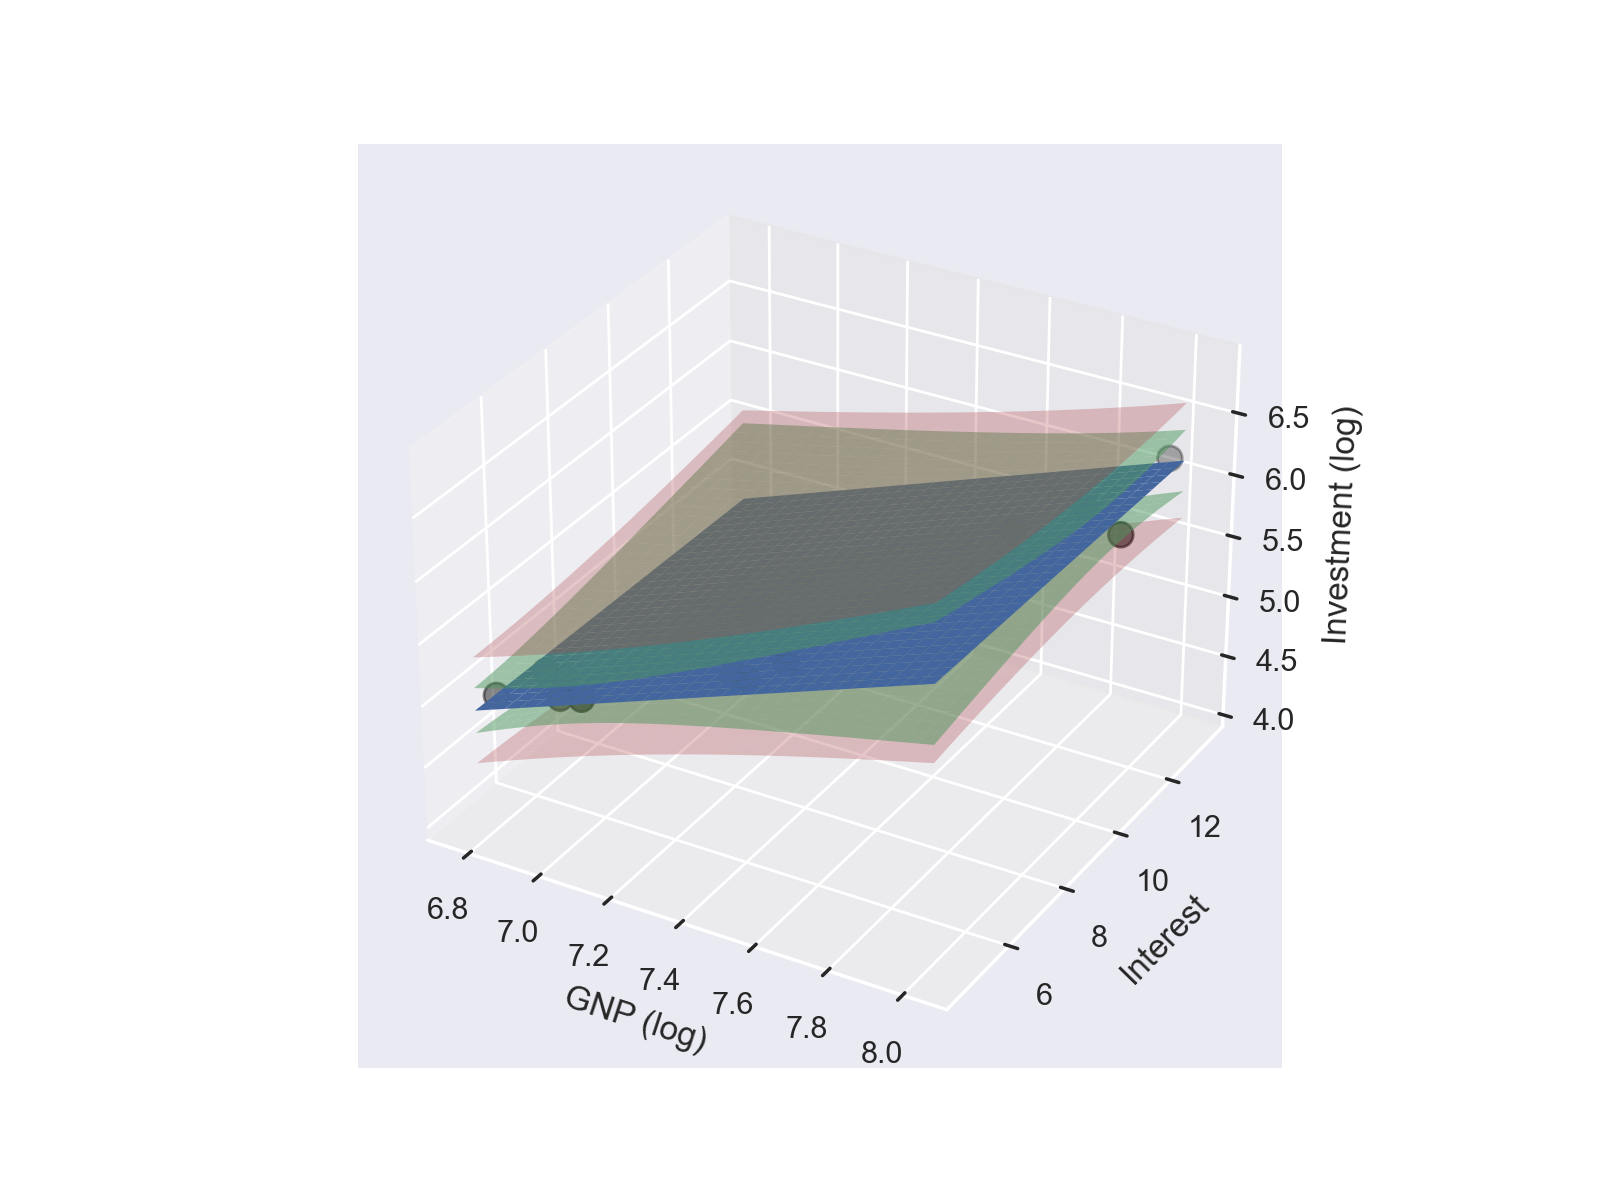

In [25]:
N_points = 30 # "Résolution" du mesh

# Création du mesh (grille de points (x, y) pour les variables d'entrée)
z_min = z.min(axis=0)
z_max = z.max(axis=0)
x1 = np.linspace(z_min[1], z_max[1], num=N_points)
x2 = np.linspace(z_min[2], z_max[2], num=N_points)
x1_mesh, x2_mesh = np.meshgrid(x1,x2)
size = x1_mesh.size
z_mesh = np.array([np.ones(size), x1_mesh.flatten(), x2_mesh.flatten()]).T

# Calcul des prédictions sur le mesh produit
y_hat = np.dot(z_mesh, beta)

# Calcul des intervalles de confiance CI pour la valeur prédite Y*
t_999 = t.ppf(1 - (0.001/ 2), n - 3)
temp = np.dot(z_mesh, gram_inverse)
temp = np.dot(temp, z_mesh.transpose())
di = np.diag_indices(N_points ** 2) # Seules les valeurs diagonales nous intéressent
temp = temp[di]
CI_width = t_999 * np.sqrt(noise_hat3) * np.sqrt(temp)
CI_inf = (y_hat - CI_width).reshape(N_points, N_points) # Redimensionnemeny pour le plot_surface
CI_sup = (y_hat + CI_width).reshape(N_points, N_points)

# Calcul des intervalles de confiance PI pour la valeur à expliquer Y
temp = 1 + temp
PI_width = t_999 * np.sqrt(noise_hat3) * np.sqrt(temp)
PI_inf = (y_hat - PI_width).reshape(N_points, N_points)
PI_sup = (y_hat + PI_width).reshape(N_points, N_points)


ax = plt.figure().add_subplot(projection='3d')

# Plot the surface
ax.plot_surface(x1_mesh, x2_mesh, y_hat.reshape(N_points, N_points),
                linewidth=0, color='b', label="Plan de prédiction")
ax.plot_surface(x1_mesh, x2_mesh, CI_inf,
                linewidth=0.0, alpha=0.5, color='g', label="Intervalle de confiance CI")
ax.plot_surface(x1_mesh, x2_mesh, CI_sup,
                linewidth=0.0, alpha=0.5, color='g')
ax.plot_surface(x1_mesh, x2_mesh, PI_inf,
                linewidth=0.0, alpha=0.3, color='r', label="Intervalle de confiance PI")
ax.plot_surface(x1_mesh, x2_mesh, PI_sup,
                linewidth=0.0, alpha=0.3, color='r')
ax.scatter(z[:, 1], z[:, 2], y, s=80, color='black', label="Observations")

ax.set_xlabel('GNP (log)')
ax.set_ylabel('Interest')
ax.set_zlabel('Investment (log)');

**Nous avons ci-dessus les représentations de la variable `Investment` (en échelle log) en fonction des variables `GNP` (en échelle log) et `Interest`.**

En légende :
- Les points noirs réprésentent les observations.
- Le plan bleu représente la régression.
- Les surfaces hyperboliques vertes et rouges translucides représentent respectivement les intervalles de confiances CI et PI.

On observe bien l'élargissement des "surfaces" de confiance par rapport à la question 6.

On notera également que les surfaces restent resserées autour du centre de gravité des observations et s'éloignent les unes des autres à mesure que l'on s'en éloigne, suivant l'axe `Interest` comme suivant l'axe `GNP`. 

## Question 13

In [26]:
# Initialisation et fit de l'estimateur
lr = LinearRegression()
lr.fit(z[:, 1:], y.reshape(-1, 1));

In [27]:
# Calcul et affichage des principales valeurs
beta0_lr = lr.intercept_[0]
beta1_lr = lr.coef_[0, 0]
beta2_lr = lr.coef_[0, 1]

print(f"L'intercept de la régression est : {beta0_lr:.4f}")
print(f"Le coefficient de régression pour la variable GNP est : {beta1_lr:.4f}")
print(f"Le coefficient de régression pour la variable Interest est : {beta2_lr:.4f}")

y_hat_lr = lr.predict(z[:, 1:])
print(f"Le coefficient de détermination est : {r2_score(y, y_hat_lr):.3f}")

y_hat_ref = lr.predict(z_predict[1:].reshape(1, -1))
y_hat_ref = y_hat_ref[0][0]
print(f"Pour GNP={ref[1]} et Interest={ref[2]}, alors l'investissement prédit par le modèle \
est de : {np.exp(y_hat_ref):.3f} (en valeur log : {(y_hat_ref):.3f})")

L'intercept de la régression est : -2.1805
Le coefficient de régression pour la variable GNP est : 1.0512
Le coefficient de régression pour la variable Interest est : -0.0065
Le coefficient de détermination est : 0.963
Pour GNP=1000 et Interest=10, alors l'investissement prédit par le modèle est de : 150.804 (en valeur log : 5.016)


**Nous retrouvons les valeurs des questions 10 et 11 !**